<font size=10>Laboratory Assignment 5</font>

# Introduction
In this laboratory, we will cover the basic element of programming using a map-reduce methodology. For that purpose, we will be using Apache Spark as a reference, but bear in mind that similar frameworks exists and principles can be extrapolated.

## Some concepts and facts

- Spark is a distributed computing platform that operates on a cluster. Like MPI, we expect that nodes does NOT share a memory space but they are connected in high-speed dedicated network. Distributed filesystems that work over the network are extremely useful.

- It is considered the next generation of previous map-reduce standard Apache Hadoop. Main difference is thought to be the use of the memory instead of diks for intermediate operations, but there are many more improvements.

- It is built on Java. Despite this, it can be programmed using Java, Scala, Python or R. The complete API can only be found in JVM-based languages but the most frequent one is PySpark, since people is reluctant to use JVM-based languages in datascience. Indeed, since Hadoop was only available for Java, it is likely that Java codes of Spark are adaptations of previous Hadoop codes.

- Resilient Distributed Dataset (RDD): the basic unit that is processed in Spark. Equivalent to a numpy array but distributed.

- RDD API usually exposes the low-level operations of Apache Spark, useful for preprocessing data but useless for data analytics

- For data analysis, Dataframe and Spark SQL is used. It relies on a pandas-alike API that even accepts SQL code (which may sound crazy and useless for developers, but many *old* data scientists and statisticians are really proficient in SQL but not in Python).

## How to install Spark in colab.

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install JVM v8
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz # Download latest release. Update if necessary
!tar xf spark-2.4.5-bin-hadoop2.7.tgz # Unzip
!pip install pyspark # Well, the library itself
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

## How to initialize Spark

In [0]:
from pyspark.sql import SparkSession

APP_NAME = "ASP-lab5"
SPARK_URL = "local[*]"
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()
sc = spark.sparkContext

# First Part: RDDs

## Basic operations

### Parallelize & collect

It creates a RDD out of a list or array. Second argument indicates the number of pieces of the RDD

In [5]:
array = sc.parallelize([1,2,3,4,5,6,7,8,9,10], 2)
array

ParallelCollectionRDD[0] at parallelize at PythonRDD.scala:195

In [6]:
import numpy as np
randomSamples = sc.parallelize(np.random.randn(100))
randomSamples

ParallelCollectionRDD[1] at parallelize at PythonRDD.scala:195

Cool, RDDs can not be printed...

Of course, RDDs can not be printed unless they are reduced

In [7]:
print(array.collect())
print(randomSamples.collect())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1.0316351917246889, 0.2510935365525939, 0.2632292769430023, -0.9663908328001213, -1.6735404977448685, -0.6534113329898058, 0.5124424212178246, -0.9858989282062233, 1.1468242928795593, -0.6714293524698919, 0.6508930044429444, -0.5901161501853834, 1.108993987981121, -0.014496605520469687, 0.5312843354715578, 1.887478574995734, -0.02549689124806018, -1.6013075180833922, -0.9027647242001101, 0.5572883736873793, 0.39415510359261396, -0.4790926836933066, 1.1455670463969645, 0.5403334726524687, -0.5706026197827702, -0.15667531473513913, 1.079204744537613, -0.20491441645202346, -0.08184086979927854, 0.07255463261176441, -0.48704137355906524, -0.9268850058447552, -0.18159473277655402, 1.1060939012529514, -1.6163465601877929, -0.007157220267033592, -2.220531546627334, -2.2534083287226525, 0.19128837597364115, 0.8116625467244827, -0.8836104539107382, 1.1886778779801432, 0.008540552997608088, 0.05899338250145, 0.7956526528966145, 0.3881735594868813, -1.240995768231

Spark uses lazy operations for everything, this means that nothing is evaluated until an action, a reduce operation normally, is performed. The basic reduce operation is collect, which returns the whole RDD (i.e. no reduction is performed).

### Other ways of loading data

In [0]:
import requests

request = requests.get("https://gist.githubusercontent.com/jsdario/6d6c69398cb0c73111e49f1218960f79/raw/8d4fc4548d437e2a7203a5aeeace5477f598827d/el_quijote.txt")
with open("elquijote.txt", "wb") as f:
  f.write(request.content) 

In [9]:
quijote = sc.textFile("elquijote.txt")
quijote.take(10)

['DON QUIJOTE DE LA MANCHA',
 'Miguel de Cervantes Saavedra',
 '',
 'PRIMERA PARTE',
 'CAPÍTULO 1: Que trata de la condición y ejercicio del famoso hidalgo D. Quijote de la Mancha',
 'En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua, rocín flaco y galgo corredor. Una olla de algo más vaca que carnero, salpicón las más noches, duelos y quebrantos los sábados, lentejas los viernes, algún palomino de añadidura los domingos, consumían las tres partes de su hacienda. El resto della concluían sayo de velarte, calzas de velludo para las fiestas con sus pantuflos de lo mismo, los días de entre semana se honraba con su vellori de lo más fino. Tenía en su casa una ama que pasaba de los cuarenta, y una sobrina que no llegaba a los veinte, y un mozo de campo y plaza, que así ensillaba el rocín como tomaba la podadera. Frisaba la edad de nuestro hidalgo con los cincuenta años, era de 

Here, you can see both a method to load a text file line per line and a another reduction operation.

In [0]:
quijote.take?

### Transformations

Let's review all the transformation that can be performed to data.

In [0]:
charsPerLine = quijote.map(lambda s: len(s))
allWords = quijote.flatMap(lambda s: s.split())
allWordsNoArticles = allWords.filter(lambda a: a.lower() not in ["el", "la"])
allWordsUnique = allWords.map(lambda s: s.lower()).distinct()
sampleWords = allWords.sample(withReplacement=True, fraction=0.2, seed=666)
weirdSampling = sampleWords.union(allWordsNoArticles.sample(False, fraction=0.3))

In [16]:
charsPerLine.take(10)

[24, 28, 0, 13, 94, 3080, 526, 595, 33, 918]

In [15]:
allWords.take(10)

['DON',
 'QUIJOTE',
 'DE',
 'LA',
 'MANCHA',
 'Miguel',
 'de',
 'Cervantes',
 'Saavedra',
 'PRIMERA']

In [12]:
allWordsUnique.take(10)

['don',
 'mancha',
 'saavedra',
 'primera',
 'parte',
 '1:',
 'que',
 'condición',
 'y',
 'del']

In [13]:
allWordsNoArticles.take(10)

['DON',
 'QUIJOTE',
 'DE',
 'MANCHA',
 'Miguel',
 'de',
 'Cervantes',
 'Saavedra',
 'PRIMERA',
 'PARTE']

In [17]:
sampleWords.take(10)

['DON', 'Que', 'ejercicio', 'del', 'D.', 'la', 'no', 'ha', 'hidalgo', 'de']

In [18]:
weirdSampling.take(10)

['DON', 'Que', 'ejercicio', 'del', 'D.', 'la', 'no', 'ha', 'hidalgo', 'de']

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each operation above.

Comment also on the size of the resulting RDD in terms of the size of the original RDD, e.g. if original RDD is of size $N$, then rdd.filter() is of size $K\leq N$

--------
Answer: (en Notas)
- map: N
- flatMap: N
- filter: N
- distinct: N
- sample: N
- union: N

----

 ### Actions

 

In [24]:
numLines = quijote.count()
numChars = charsPerLine.reduce(lambda a,b: a+b) # also charsPerLine.sum()
sortedWordsByLength = allWordsNoArticles.takeOrdered(10, key=lambda x: -len(x))
numLines, numChars, sortedWordsByLength

(2186,
 1036211,
 ['procuremos.Levántate,',
  'extraordinariamente,',
  'estrechísimamente,',
  'convirtiéndoseles',
  'entretenimientos,',
  'inadvertidamente.',
  'cortesísimamente',
  'Agredeciéronselo',
  'Pintiquiniestra,',
  'entretenimiento,'])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the count operation using reduce as the unique action. You can use transformations. Is it possible to achieve a solution without any transformation? Does it make sense?

--------
Answer:


In [23]:
numLines1 = quijote.map(lambda a: 1).reduce(lambda a,b: a+b)
numLines1

2186

In [25]:
# ejemplo de como hacer un reduce
def reduceFunction(a, b):
  if isinstance(a, str):
    a = 1
  if isinstance(b, str):
    b = 1
  return a + b
quijote.reduce(reduceFunction)

2186

----

## Key-Value RDDs

In [0]:
import re
allWords = allWords.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.lower()).split(" ")).filter(lambda a: len(a)>0)
allWords2 = sc.parallelize(requests.get("https://gist.githubusercontent.com/jsdario/9d871ed773c81bf217f57d1db2d2503f/raw/585de69b0631c805dabc6280506717943b82ba4a/el_quijote_ii.txt").iter_lines())
allWords2 = allWords2.flatMap(lambda w: re.sub(""";|:|\.|,|-|–|"|'|\s"""," ", w.decode("utf8").lower()).split(" ")).filter(lambda a: len(a)>0)

In [27]:
allWords.take(10), allWords2.take(10)

(['don',
  'quijote',
  'de',
  'la',
  'mancha',
  'miguel',
  'de',
  'cervantes',
  'saavedra',
  'primera'],
 ['don',
  'quijote',
  'de',
  'la',
  'mancha',
  'miguel',
  'de',
  'cervantes',
  'saavedra',
  'segunda'])

Next, we move to more interesting operations that involve key-value RDDs. Key-value RDDs are a special kind of RDDs where each is element is a tuple (K,V) where K is the key and V the value.

In [29]:
words = allWords.map(lambda e: (e,1))
words2 = allWords2.map(lambda e: (e,1))

words.take(10)

[('don', 1),
 ('quijote', 1),
 ('de', 1),
 ('la', 1),
 ('mancha', 1),
 ('miguel', 1),
 ('de', 1),
 ('cervantes', 1),
 ('saavedra', 1),
 ('primera', 1)]

### How to manipulate K-V RDDs

In [30]:
frequencies = words.reduceByKey(lambda a,b: a+b)
frequencies2 = words2.reduceByKey(lambda a,b: a+b)
frequencies.takeOrdered(10, key=lambda a: -a[1])

[('que', 10705),
 ('de', 9033),
 ('y', 8668),
 ('la', 5015),
 ('a', 4815),
 ('en', 4046),
 ('el', 3857),
 ('no', 3083),
 ('se', 2382),
 ('los', 2148)]

In [31]:
res = words.groupByKey().takeOrdered(10, key=lambda a: -len(a))
res # To see the content, res[i][1].data

[('don', <pyspark.resultiterable.ResultIterable at 0x7fde566ae940>),
 ('mancha', <pyspark.resultiterable.ResultIterable at 0x7fde566aeb70>),
 ('saavedra', <pyspark.resultiterable.ResultIterable at 0x7fde566aeba8>),
 ('primera', <pyspark.resultiterable.ResultIterable at 0x7fde566aec18>),
 ('parte', <pyspark.resultiterable.ResultIterable at 0x7fde566aec88>),
 ('1', <pyspark.resultiterable.ResultIterable at 0x7fde566aecc0>),
 ('que', <pyspark.resultiterable.ResultIterable at 0x7fde566aed30>),
 ('condición', <pyspark.resultiterable.ResultIterable at 0x7fde566aed68>),
 ('y', <pyspark.resultiterable.ResultIterable at 0x7fde566aeda0>),
 ('del', <pyspark.resultiterable.ResultIterable at 0x7fde566aee10>)]

In [34]:
joinFreq = frequencies.join(frequencies2)
joinFreq.takeOrdered(10, key=lambda a: -(a[1][0] + a[1][1]))

[('que', (10705, 10040)),
 ('de', (9033, 9367)),
 ('y', (8668, 9650)),
 ('la', (5015, 5461)),
 ('a', (4815, 5072)),
 ('en', (4046, 4223)),
 ('el', (3857, 4394)),
 ('no', (3083, 3227)),
 ('los', (2148, 2612)),
 ('se', (2382, 2357))]

In [33]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1]), joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

--------


<font size=10 color=red>Assignment question</font>

Explain the use and purpose of each action above.

Implement the frequency with groupByKey and transformations.

Which of the two following cells is more efficient?

--------
Answer:


In [41]:
words.groupByKey().map(lambda e:(e[0], sum(e[1]))).takeOrdered(10, key=lambda a: -a[1])

[('que', 10705),
 ('de', 9033),
 ('y', 8668),
 ('la', 5015),
 ('a', 4815),
 ('en', 4046),
 ('el', 3857),
 ('no', 3083),
 ('se', 2382),
 ('los', 2148)]

------

In [42]:
joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: -v[1]), joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1]))).takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

In [43]:
result = joinFreq.map(lambda e: (e[0], (e[1][0] - e[1][1])/(e[1][0] + e[1][1])))
result.takeOrdered(10, lambda v: -v[1]), result.takeOrdered(10, lambda v: +v[1])

([('bacía', 0.9393939393939394),
  ('venia', 0.9230769230769231),
  ('hermandad', 0.9),
  ('andrés', 0.8823529411764706),
  ('peña', 0.8823529411764706),
  ('micomicona', 0.8823529411764706),
  ('barca', 0.875),
  ('novela', 0.875),
  ('yerme', 0.875),
  ('acertó', 0.8666666666666667)],
 [('teresa', -0.9767441860465116),
  ('roque', -0.96),
  ('refranes', -0.9375),
  ('condesa', -0.9333333333333333),
  ('leones', -0.9333333333333333),
  ('gobernadores', -0.9166666666666666),
  ('lacayo', -0.9166666666666666),
  ('visorrey', -0.9130434782608695),
  ('antonio', -0.9076923076923077),
  ('zaragoza', -0.9047619047619048)])

Las dos son iguales, la de abajo es más elegante. (Ver notas).

## Optimizations and final notes

### Optimizing the data movement around the cluster

One of the main issues could be that if data after an operation is not balanced, we may not be using the cluster properly. For that purpose, we have two operations


In [50]:
result.coalesce(numPartitions=6) # Avoids the data movement, so it tries to balance inside each machine
result.repartition(numPartitions=6) # We don't care about data movement, this balance the whole thing to ensure all machines are used

MapPartitionsRDD[128] at coalesce at NativeMethodAccessorImpl.java:0

### Persistance for intermediate operations
In contrast to Hadoop, intermediate RDDs are not preserved, each time we use an action/reduction, the whole data pipeline is executed from the datasources. To avoid this:


In [55]:
result.take(10)
allWords.cache() # allWords RDD must  stay in memory after computation, we made a checkpoint (well, it's a best effort, so must might be too strong)
result.take(10)

[('don', -0.19940253920836445),
 ('mancha', -0.33774834437086093),
 ('saavedra', 0.3333333333333333),
 ('primera', -0.1702127659574468),
 ('parte', 0.05952380952380952),
 ('1', 0.0),
 ('que', 0.03205591708845505),
 ('condición', -0.08333333333333333),
 ('y', -0.05360847254067038),
 ('del', -0.08737864077669903)]

In [56]:
from pyspark import StorageLevel
# https://spark.apache.org/docs/2.2.0/rdd-programming-guide.html#rdd-persistence
allWords2.persist(StorageLevel.MEMORY_AND_DISK) # Now it will be preserved on disk also

PythonRDD[119] at RDD at PythonRDD.scala:53

In [0]:
!rm -rf palabras_parte2
allWords2.saveAsTextFile("palabras_parte2")

In [58]:
!ls palabras_parte2

part-00000  part-00001	_SUCCESS


--------


<font size=10 color=red>Assignment question</font>

Before saving with saveAsTextFile, use coalesce with different values. What's the difference in the previous ls? 

--------
Answer:

----

### Global variables

There are two kind of global variables, read-only and write-only.

In [0]:
articles = sc.broadcast(["el", "la"])
articles.value

['el', 'la']

Broadcast variables are read-only. They help us to avoid local variables of the closures (the functions we use inside map, reduce, ...) to be transferred in every single Spark operation. In that way, they are only transferred only once.

In [59]:
acc = sc.accumulator(0)
def incrementar(x):
  global acc
  acc += x

allWords.map(lambda l:1).foreach(incrementar)
acc

Accumulator<id=0, value=187045>

Write-only variables can be also declared and initialized, but they can not be read since reading will force a complete synchronization of the cluster.

# Second part: Spark SQL

Next, we will do a short review of the high-level API of Spark

In [0]:
import pandas as pd

size = int(1e6)
def loadRedditToPandas(subreddit=None, size=size):
  if subreddit is not None:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?subreddit={subreddit}&sort=desc&sort_type=created_utc&size={size:d}").json()
  else:
    redditData = requests.get(f"https://api.pushshift.io/reddit/search/submission/?sort=desc&sort_type=created_utc&size={size:d}").json()
  return pd.DataFrame(redditData["data"])

In [62]:
pdf = loadRedditToPandas()
pdf.head(10)

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,awarders,can_mod_post,content_categories,contest_mode,created_utc,domain,full_link,gildings,id,is_crosspostable,is_meta,is_original_content,is_reddit_media_domain,is_robot_indexable,is_self,is_video,link_flair_background_color,link_flair_richtext,link_flair_text_color,link_flair_type,locked,media_only,no_follow,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,post_hint,...,thumbnail_height,thumbnail_width,title,total_awards_received,treatment_tags,upvote_ratio,url,whitelist_status,wls,link_flair_css_class,link_flair_template_id,link_flair_text,suggested_sort,media,media_embed,secure_media,secure_media_embed,media_metadata,removed_by_category,crosspost_parent,crosspost_parent_list,author_flair_template_id,author_flair_text_color,author_cakeday,author_flair_background_color,distinguished,poll_data,discussion_type,author_id,call_to_action,domain_override,events,eventsOnRender,href_url,is_blank,mobile_ad_url,outbound_link,promoted,show_media,third_party_trackers
0,[],False,obtp,None,[],None,text,t2_6676651g,False,False,[],False,[photography],False,1588613363,i.redd.it,https://www.reddit.com/r/pics/comments/gdfy49/...,{},gdfy49,True,False,False,True,True,False,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/pics/comments/gdfy49/they_do_think_we_cant_...,False,image,...,140.0,140.0,They do think we cant understand,0,[],1.0,https://i.redd.it/f46nlnri9sw41.jpg,all_ads,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,MonchiMonchi,None,[],None,text,t2_568yw4lb,False,False,[],False,NaN,False,1588613363,self.stimuluscheck,https://www.reddit.com/r/stimuluscheck/comment...,{},gdfy47,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,NaN,/r/stimuluscheck/comments/gdfy47/really_quick_...,False,NaN,...,NaN,NaN,Really quick question.,0,[],1.0,https://www.reddit.com/r/stimuluscheck/comment...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,sw201444,None,[],None,text,t2_dhdgh,False,False,[],False,NaN,False,1588613363,self.AquaSwap,https://www.reddit.com/r/AquaSwap/comments/gdf...,{},gdfy46,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/AquaSwap/comments/gdfy46/fsft_cincinnati_oh...,False,self,...,NaN,NaN,"[FS/FT] - Cincinnati, OH - $1.50+ Spixi Snails...",0,[],1.0,https://www.reddit.com/r/AquaSwap/comments/gdf...,all_ads,6.0,FSFT,f01b6464-3f5e-11e6-b319-0efa4f51ea4d,For Sale/For Trade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,savetheworld111,None,[],None,text,t2_69qjg5sw,False,False,[],False,NaN,False,1588613363,self.LGBTPolitics,https://www.reddit.com/r/LGBTPolitics/comments...,{},gdfy45,True,False,False,False,True,True,False,,[],dark,text,False,False,True,0,0,False,NaN,/r/LGBTPolitics/comments/gdfy45/this_link_send...,False,self,...,NaN,NaN,This link sends an automatic email to our legi...,0,[],1.0,https://www.reddit.com/r/LGBTPolitics/comments...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,Shyohh,None,[],None,text,t2_52di8b1x,False,False,[],False,NaN,False,1588613363,i.redd.it,https://www.reddit.com/r/ksi/comments/gdfy44/i...,{},gdfy44,True,False,False,True,True,False,False,,[],dark,text,False,False,True,0,0,False,all_ads,/r/ksi/comments/gdfy44/it_izz_what_it_izz/,False,image,...,68.0,140.0,it izz what it izz,0,[],1.0,https://i.redd.it/cwa79ofl9sw41.png,all_ads,6.0,NaN,NaN,NaN,confidence,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,[],False,

In [0]:
pdf.selftext = pdf.selftext.apply(lambda e: str(e))

In [0]:
attrs = ["author", "created_utc", "title", "subreddit", "selftext", "over_18"]
df = spark.createDataFrame(pdf[attrs])

## Basic operations

In [68]:
df = df.filter("not over_18")
df.show()

+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|            author|created_utc|                                title|          subreddit|            selftext|over_18|
+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|              obtp| 1588613363|                 They do think we ...|               pics|                    |  false|
|      MonchiMonchi| 1588613363|                 Really quick ques...|      stimuluscheck|I requested the s...|  false|
|          sw201444| 1588613363|                 [FS/FT] - Cincinn...|           AquaSwap|NO SHIPPING. 

Sp...|  false|
|   savetheworld111| 1588613363|                 This link sends a...|       LGBTPolitics|[https://nextgena...|  false|
|            Shyohh| 1588613363|                   it izz what it izz|                ksi|                    |  false|
|       mrfatpepper| 1588613363|        

### Filtering

In [67]:
df.filter(~df.over_18).show()

+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|            author|created_utc|                                title|          subreddit|            selftext|over_18|
+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|              obtp| 1588613363|                 They do think we ...|               pics|                    |  false|
|      MonchiMonchi| 1588613363|                 Really quick ques...|      stimuluscheck|I requested the s...|  false|
|          sw201444| 1588613363|                 [FS/FT] - Cincinn...|           AquaSwap|NO SHIPPING. 

Sp...|  false|
|   savetheworld111| 1588613363|                 This link sends a...|       LGBTPolitics|[https://nextgena...|  false|
|            Shyohh| 1588613363|                   it izz what it izz|                ksi|                    |  false|
|       mrfatpepper| 1588613363|        

In [69]:
df.where(~df.over_18).show()

+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|            author|created_utc|                                title|          subreddit|            selftext|over_18|
+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|              obtp| 1588613363|                 They do think we ...|               pics|                    |  false|
|      MonchiMonchi| 1588613363|                 Really quick ques...|      stimuluscheck|I requested the s...|  false|
|          sw201444| 1588613363|                 [FS/FT] - Cincinn...|           AquaSwap|NO SHIPPING. 

Sp...|  false|
|   savetheworld111| 1588613363|                 This link sends a...|       LGBTPolitics|[https://nextgena...|  false|
|            Shyohh| 1588613363|                   it izz what it izz|                ksi|                    |  false|
|       mrfatpepper| 1588613363|        

In [70]:
df.where("not over_18").show() # SQL syntax

+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|            author|created_utc|                                title|          subreddit|            selftext|over_18|
+------------------+-----------+-------------------------------------+-------------------+--------------------+-------+
|              obtp| 1588613363|                 They do think we ...|               pics|                    |  false|
|      MonchiMonchi| 1588613363|                 Really quick ques...|      stimuluscheck|I requested the s...|  false|
|          sw201444| 1588613363|                 [FS/FT] - Cincinn...|           AquaSwap|NO SHIPPING. 

Sp...|  false|
|   savetheworld111| 1588613363|                 This link sends a...|       LGBTPolitics|[https://nextgena...|  false|
|            Shyohh| 1588613363|                   it izz what it izz|                ksi|                    |  false|
|       mrfatpepper| 1588613363|        

### Operations



In [71]:
df.select(df.created_utc * 2).show()

+-----------------+
|(created_utc * 2)|
+-----------------+
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226726|
|       3177226724|
|       3177226724|
|       3177226724|
|       3177226724|
|       3177226724|
|       3177226724|
|       3177226724|
+-----------------+
only showing top 20 rows



In [73]:
from pyspark.sql.functions import log
df.select(log(df.created_utc * 2)).show()

+----------------------+
|LOG((created_utc * 2))|
+----------------------+
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274554497012|
|    21.879274553867532|
|    21.879274553867532|
|    21.879274553867532|
|    21.879274553867532|
|    21.879274553867532|
|    21.879274553867532|
|    21.879274553867532|
+----------------------+
only showing top 20 rows



### Aggregations



In [74]:
df.where("not over_18").groupby(["author", df.subreddit]).count().toPandas()

,author,subreddit,count
0,nuje_nuje,modular,1
1,MelvilleIsland,techsupport,1
2,jbrower02,Televisions,1
3,Daydream_Tm,Badfaketexts,1
4,ZincAdaptive,peace,1
...,...,...,...
767,Vaporwave-Cycl0n3,u_Vaporwave-Cycl0n3,1
768,damuammu,Damnthatsinteresting,1
769,ChiefPez,yellowplants,1
770,IamSOveryDEEP,OCPoetry,1


### Custom functions

In [76]:
from pyspark.sql.functions import length

df = df.withColumn("length", length(df.selftext)) # This adds a column

df.where("length > 1000").toPandas()

,author,created_utc,title,subreddit,selftext,over_18,length
0,MinecraftUniversity,1588613362,Hey my friends and I created a Minecraft serve...,UGA,Howdy Bulldogs!\n\nMinecraft University is a M...,False,1026
1,Laadoxking,1588613359,"A funny bug that happened to me a while ago, w...",wow,"We werde in the set to raid Stormwind: So big,...",False,1192
2,Rextar2003,1588613357,Should I study law... in Bulgaria?,LawSchool,"Hello, I'm trying to decide should I study law...",False,1078
3,gunner007CCD,1588613356,[California] Confused between PPP and UI Benef...,Unemployment,So I'm super confused on how the formula works...,False,1417
4,PattuX,1588613351,Why are there researchers contradicting basica...,AskScienceDiscussion,My mom is very much into the Vitamin D hype. I...,False,1552
5,gzenne,1588613350,Manhwa/Manga/Manhua to read while waiting for ...,sololeveling,I recommend these if you like SL:\n\n- The Gre...,False,1075
6,iverstaylot00,1588613348,Missed steps?,ender5,Hi all. Recently I've been getting these lines...,False,1121
7,counthawkula,1588613348,[HR] Be Smart,shortstories,First Post. Playing around with present and pa...,False,7202
8,zcovey9,1588613343,GruntLife Gaming [NA][PC][EFT][18+] Military V...,EFT_LFG,I've been gaming with a good group of people w...,False,1049
9,DeerTrivia,1588613341,Optimized Bounties For 5/4/2020,DestinyTheGame,\nDeer trivia: Fawns learn about social hierar...,False,2681


In [77]:
from pyspark.sql.functions import udf

def splitWords(e):
  return e.split(" ")

splitWords = udf(splitWords)
df.select(splitWords(df.selftext)).show()

+--------------------+
|splitWords(selftext)|
+--------------------+
|                  []|
|[I, requested, th...|
|[NO, SHIPPING., 
...|
|[[https://nextgen...|
|                  []|
|                  []|
|[[https://www.red...|
|[I, am, really, c...|
|                  []|
|[&amp;#x200B;

*P...|
|                  []|
|[hi!, sorry, if, ...|
|[#, DOWNLOAD, LIN...|
|                  []|
|         [[removed]]|
|                  []|
|[There, are, 2, t...|
|[Hello, friends!,...|
|                  []|
|[Have, any, of, y...|
+--------------------+
only showing top 20 rows



--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 2 posts in any subreddit

--------
Answer: 

In [79]:
df.groupBy(df.author, df.subreddit).count().filter("count > 2").toPandas()

,author,subreddit,count
0,not_irresponsible,LightNovelsWuxia,7
1,newsfeedmedia,newsfeedmedia,10
2,NiqqaEnthusiasm,averageredditor,3
3,bang123211342155,warface,4
4,urlradar3,formreddit,3
5,KindExamination43,u_KindExamination43,32
6,Dermaeus,memen,3
7,-en-,newsbotbot,14


-----

## SQL operations

### How to declare a view from a Dataframe

In [0]:
df.createOrReplaceTempView("reddit")

In [81]:
spark.sql("select * from reddit limit 10").show()

+---------------+-----------+--------------------+-----------------+--------------------+-------+------+
|         author|created_utc|               title|        subreddit|            selftext|over_18|length|
+---------------+-----------+--------------------+-----------------+--------------------+-------+------+
|           obtp| 1588613363|They do think we ...|             pics|                    |  false|     0|
|   MonchiMonchi| 1588613363|Really quick ques...|    stimuluscheck|I requested the s...|  false|   188|
|       sw201444| 1588613363|[FS/FT] - Cincinn...|         AquaSwap|NO SHIPPING. 

Sp...|  false|   899|
|savetheworld111| 1588613363|This link sends a...|     LGBTPolitics|[https://nextgena...|  false|   336|
|         Shyohh| 1588613363|  it izz what it izz|              ksi|                    |  false|     0|
|    mrfatpepper| 1588613363|BLACK OPS 2 ZOMBI...|SelfPromo_YouTube|                    |  false|     0|
|     Beelzeboba| 1588613363|I made a redbubbl...|     

--------


<font size=10 color=red>Assignment question</font>

Obtain the users who have posted in reddit more than 2 posts in any subreddit

--------
Answer:

In [82]:
spark.sql("""select * from (select(*) from reddit where length(reddit.selftext) > 1000 groupby subreddit)""").show()

ParseException: ignored

----

## Other libraries

Beyond dataframes, we can find other libraries that also rely on Spark...

In [83]:
!pip install koalas

     |████████████████████████████████| 593kB 2.8MB/s 


In [84]:
import databricks.koalas as ks
import pandas as pd

# Create a Koalas DataFrame from pandas DataFrame
kdf = ks.from_pandas(pdf[attrs])

kdf.head()

,author,created_utc,title,subreddit,selftext,over_18
0,obtp,1588613363,They do think we cant understand,pics,,False
1,MonchiMonchi,1588613363,Really quick question.,stimuluscheck,I requested the stimulus check almost a month ...,False
2,sw201444,1588613363,"[FS/FT] - Cincinnati, OH - $1.50+ Spixi Snails...",AquaSwap,NO SHIPPING. \n\nSpixi snails are $1.50+. I ha...,False
3,savetheworld111,1588613363,This link sends an automatic email to our legi...,LGBTPolitics,[https://nextgenamerica.org/act/equality-act/?...,False
4,Shyohh,1588613363,it izz what it izz,ksi,,False


In [85]:
kdf["sumChars"] = kdf.selftext.str.len()
res = kdf.groupby(["author", "subreddit"]).sum()
res[res.sumChars > 1000]

,,created_utc,sumChars
author,subreddit,,
TomGallowaySfc,ArmeniaNT,1588613300,2219
anonyMices,legaladvice,1588613339,1025
AttemptAuthenticity,sex,1588613318,2425
gzenne,sololeveling,1588613350,1075
MinecraftUniversity,UGA,1588613362,1026
Throwaway132020,DndAdventureWriter,1588613324,1101
Greyistired46_UwU,AmItheAsshole,1588613336,1195
0Seraphina0,Paranormal,1588613292,1321
iverstaylot00,ender5,1588613348,1121


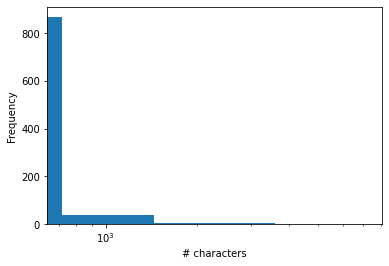

In [86]:
import matplotlib.pyplot as plt
plt.hist(res.sumChars.to_numpy())
plt.xlabel("# characters")
plt.ylabel("Frequency")
plt.xscale("log")

In [87]:
!curl https://2.bp.blogspot.com/-eGskF3n8_Ag/XE7F3P_de2I/AAAAAAAAHU8/WJw0un2nHqMGA8cFVtv_yFfpBVQJSYyVACK4BGAYYCw/s1600/Icon-Reddit.png > reddit.png
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

mask = np.array(Image.open("reddit.png"))
text = " ".join([i for i in kdf.selftext.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 76154  100 76154    0     0   357k      0 --:--:-- --:--:-- --:--:--  357k


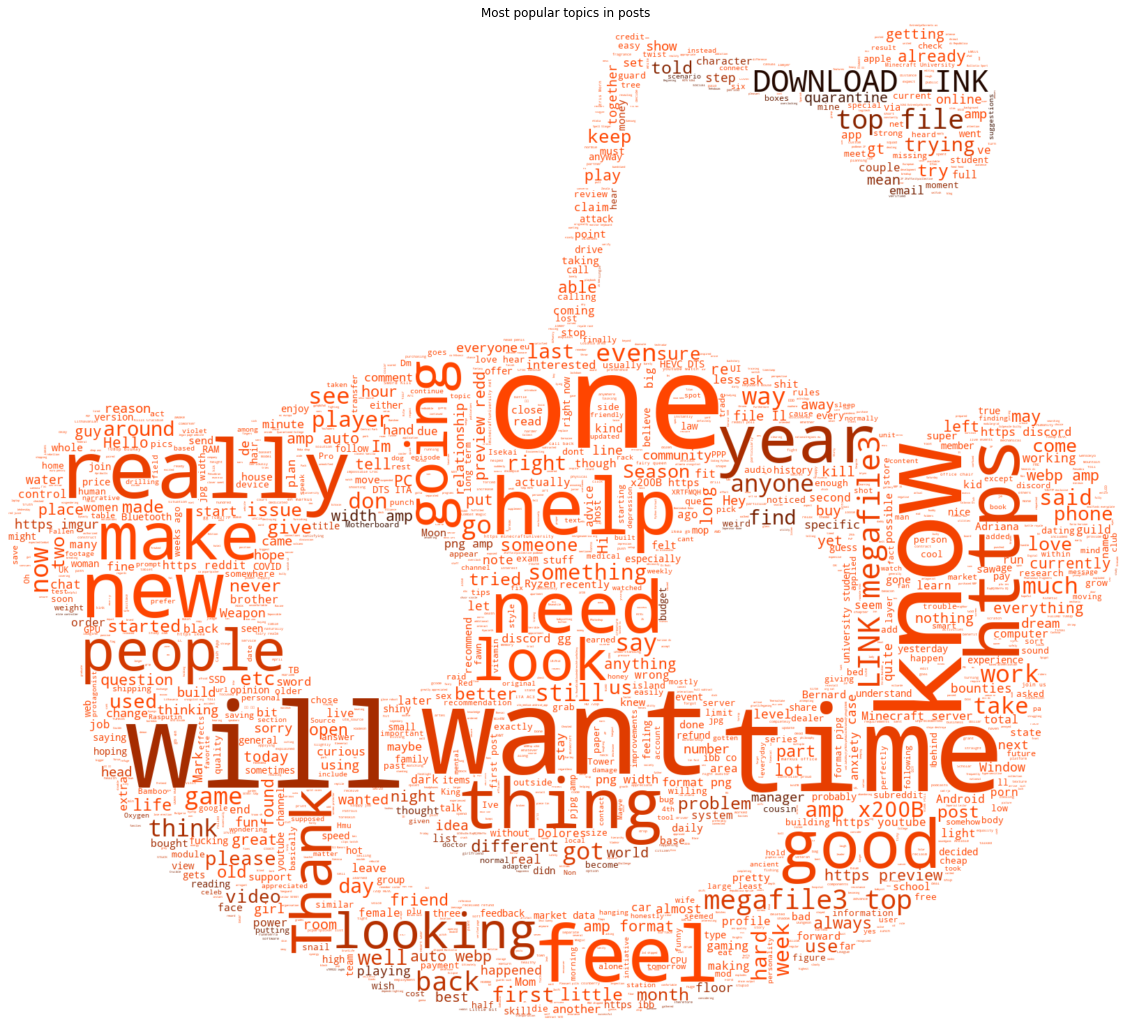

In [88]:
text = " ".join([i for i in kdf.selftext.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in posts")
plt.axis("off");

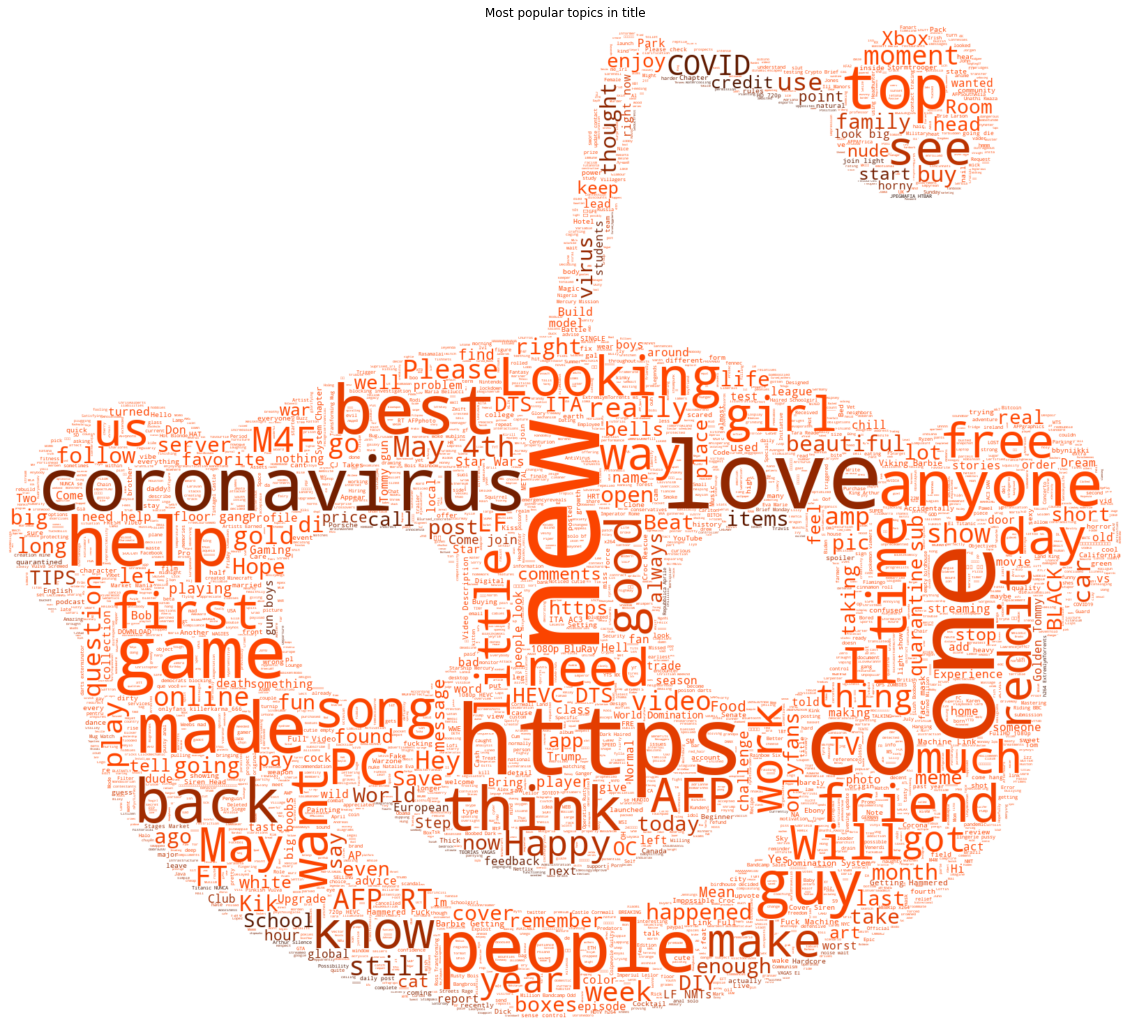

In [89]:
text = " ".join([i for i in kdf.title.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular topics in title")
plt.axis("off");

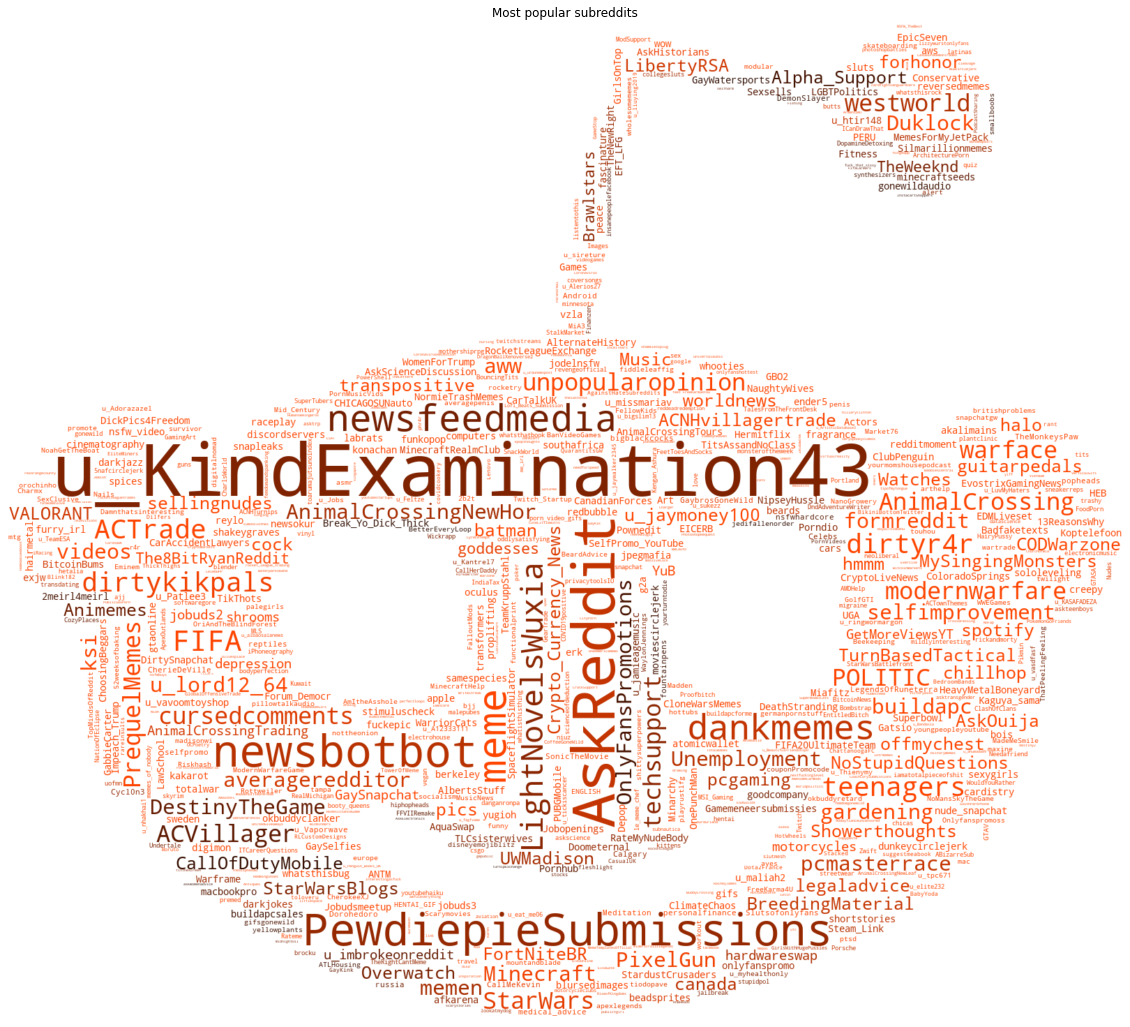

In [90]:
text = " ".join([i for i in kdf.subreddit.to_numpy() if len(i) > 0 and i != "[removed]" and i!="[deleted]"])
wordcloud = WordCloud(max_words=5000, mask=~mask[:,:,0], background_color="white", mode="RGBA").generate(text)
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.title("Most popular subreddits")
plt.axis("off");

--------


<font size=10 color=red>Assignment question</font>

Choose a subreddit you like and build a worldcloud using Koalas. Feel free to change the mask or the colors...

--------
Answer: